In [1]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn

npx.set_np()

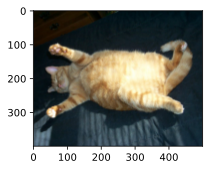

In [2]:
d2l.set_figsize()
img = image.imread('../img/cat1.jpg')
d2l.plt.imshow(img.asnumpy());

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

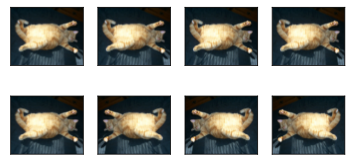

In [4]:
apply(img, gluon.data.vision.transforms.RandomFlipLeftRight())

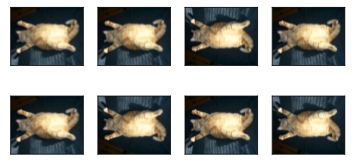

In [5]:
apply(img, gluon.data.vision.transforms.RandomFlipTopBottom())

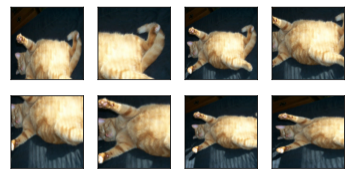

In [6]:
shape_aug = gluon.data.vision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

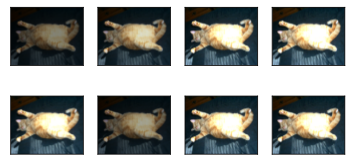

In [7]:
apply(img, gluon.data.vision.transforms.RandomBrightness(0.5))

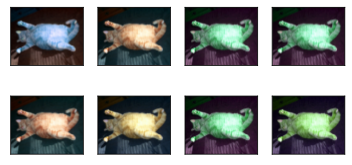

In [8]:
apply(img, gluon.data.vision.transforms.RandomHue(0.5))

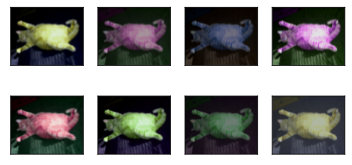

In [9]:
color_aug = gluon.data.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

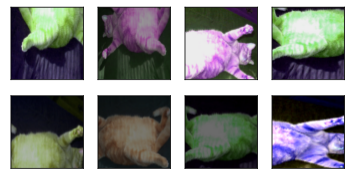

In [10]:
augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

In [11]:
d2l.show_images(gluon.data.vision.CIFAR10(
    train=True)[0:32][0], 4, 8, scale=0.8);

KeyboardInterrupt: 

In [ ]:
train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor()])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor()])

In [ ]:
def load_cifar10(is_train, augs, batch_size):
    return gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())

In [ ]:
#@save
def train_batch_ch13(net, features, labels, loss, trainer, devices,
                     split_f=d2l.split_batch):
    X_shards, y_shards = split_f(features, labels, devices)
    with autograd.record():
        pred_shards = [net(X_shard) for X_shard in X_shards]
        ls = [loss(pred_shard, y_shard) for pred_shard, y_shard
              in zip(pred_shards, y_shards)]
    for l in ls:
        l.backward()
    # The True flag allows parameters with stale gradients, which is useful
    # later (e.g., in fine-tuning BERT)
    trainer.step(labels.shape[0], ignore_stale_grad=True)
    train_loss_sum = sum([float(l.sum()) for l in ls])
    train_acc_sum = sum(d2l.accuracy(pred_shard, y_shard)
                        for pred_shard, y_shard in zip(pred_shards, y_shards))
    return train_loss_sum, train_acc_sum

In [ ]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus(), split_f=d2l.split_batch):
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # Store training_loss, training_accuracy, num_examples, num_features
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices, split_f)
            metric.add(l, acc, labels.shape[0], labels.size)
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0:
                animator.add(epoch + i / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpus(net, test_iter, split_f)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [ ]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10)
net.initialize(init=init.Xavier(), ctx=devices)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

In [ ]:
train_with_data_aug(train_augs, test_augs, net)